In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
!pip install tensorflow
!pip install kaggle

In [1]:
#from google.colab import files
#files.upload()  # This will prompt you to upload the kaggle.json file

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d prasadchaskar/indian-food-datatset
!unzip indian-food-datatset.zip -d ./data/

Dataset URL: https://www.kaggle.com/datasets/prasadchaskar/indian-food-datatset
License(s): unknown
100% 107M/107M [00:05<00:00, 27.2MB/s]
100% 107M/107M [00:05<00:00, 20.0MB/s]
Archive:  indian-food-datatset.zip
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (1).jpeg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (1).jpg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (10).jpeg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (10).jpg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (11).jpeg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (11).jpg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (12).jpeg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (12).jpg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (13).jpeg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (13).jpg  
  inflating: ./data/Indian Food Dataset/Aloo Paratha/Paratha (14

In [ ]:
import os
import shutil
import random

# Define base directory and paths for clean train/val folders
base_dir = '/content/data/Indian Food Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Remove existing train and val folders if any
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

# Recreate empty train and val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get list of all class folders in base directory
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d not in ['train', 'val']]

# Loop through each class folder to split images and copy them to train/val
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    # Create class subfolders in train and val directories
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # List images in class folder
    images = os.listdir(cls_path)
    random.shuffle(images)
    split_index = int(0.8 * len(images))  # 80% for training, 20% for validation

    # Copy images to train folder
    for img in images[:split_index]:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))

    # Copy images to val folder
    for img in images[split_index:]:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

print("Dataset structure has been organized successfully!")

Dataset structure has been organized successfully!


In [ ]:
# Step 2: Set Up Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/data/Indian Food Dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/data/Indian Food Dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 639 images belonging to 7 classes.
Found 162 images belonging to 7 classes.


In [ ]:
# Step 3: Load and Prepare MobileNetV2 Model
# Import necessary modules
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam # Import Adam optimizer
from tensorflow.keras.models import Model

# ... (rest of your existing code) ...

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 5: Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5097 - loss: 1.5243 - val_accuracy: 0.8438 - val_loss: 0.4542
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8438 - loss: 0.5899 - val_accuracy: 0.5000 - val_loss: 0.5098
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9007 - loss: 0.2896 - val_accuracy: 0.8562 - val_loss: 0.3959
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9032 - loss: 0.2685 - val_accuracy: 1.0000 - val_loss: 0.0793
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9267 - loss: 0.1919 - val_accuracy: 0.8813 - val_loss: 0.3198
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 0.0583 - val_accuracy: 1.0000 - val_loss: 0.0858
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9654 - loss: 0.1151 - val_accuracy: 0.8750 - val_loss: 0.2868
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9688 - loss: 0.0973 - val_accuracy: 1.0000 - val_loss: 0.1503
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9657 - loss: 0.0993 - val_accuracy: 0.8813 - val_loss: 0.2906
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0713 - val_accuracy: 1.0000 - val_loss: 0.0036


In [ ]:
# Save the Best Model
model.save('best_food_recognition_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/best_food_recognition_model.keras')

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9158 - loss: 0.2666
Validation Accuracy: 0.9012, Validation Loss: 0.3106


In [ ]:
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


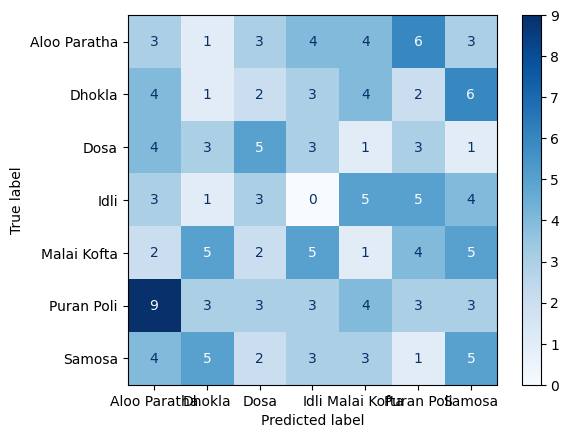

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

              precision    recall  f1-score   support

Aloo Paratha       0.10      0.12      0.11        24
      Dhokla       0.05      0.05      0.05        22
        Dosa       0.25      0.25      0.25        20
        Idli       0.00      0.00      0.00        21
 Malai Kofta       0.05      0.04      0.04        24
  Puran Poli       0.12      0.11      0.12        28
      Samosa       0.19      0.22      0.20        23

    accuracy                           0.11       162
   macro avg       0.11      0.11      0.11       162
weighted avg       0.11      0.11      0.11       162



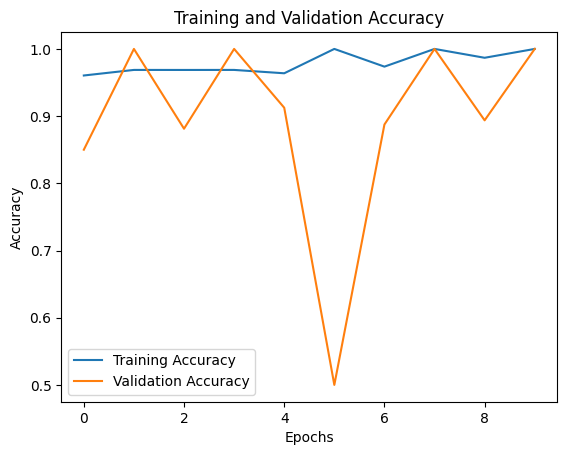

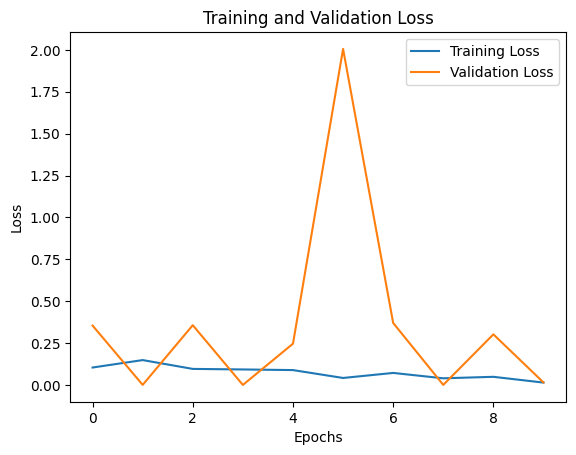

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the training history returned by `model.fit()`
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


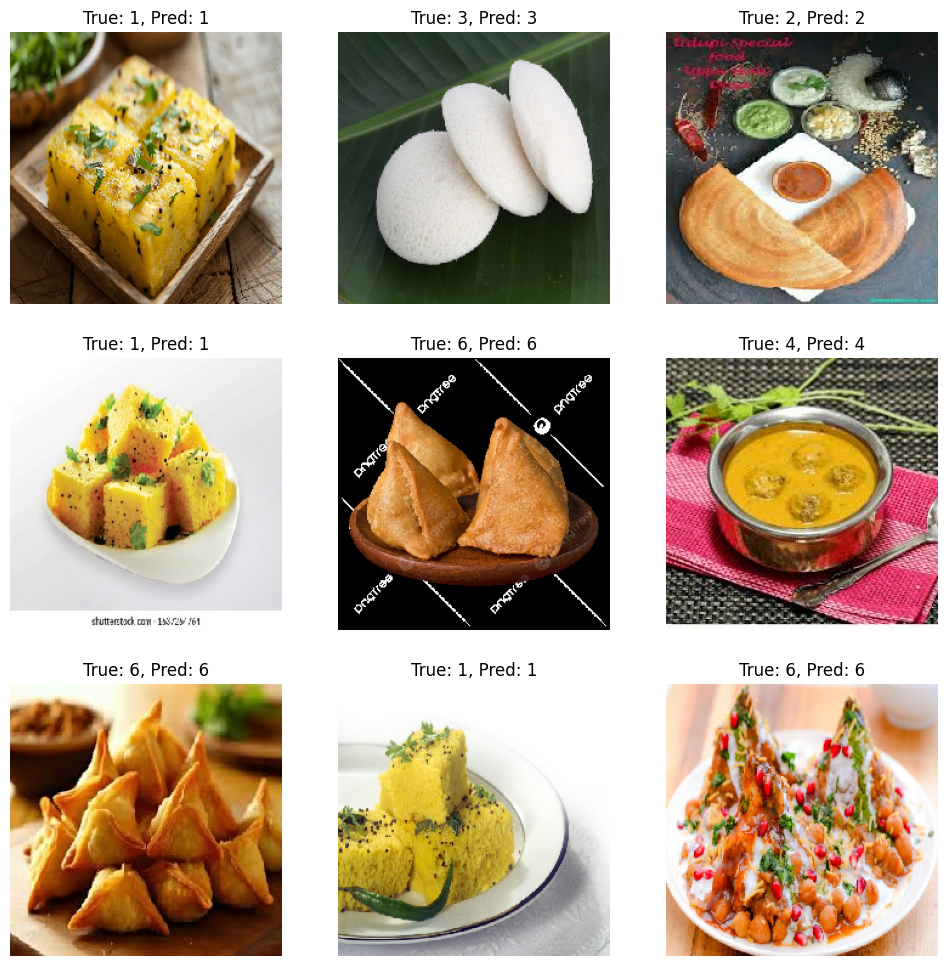

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from the validation generator
images, labels = next(val_generator)

# Make predictions
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display a few images with predicted and true labels
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# Assuming you want to print the class indices from your validation generator:
print(val_generator.class_indices)  # Shows a dictionary of class names and their indices

# If you were aiming to print them from the training generator, use:
# print(train_generator.class_indices)  # Shows a dictionary of class names and their indices

{'Aloo Paratha': 0, 'Dhokla': 1, 'Dosa': 2, 'Idli': 3, 'Malai Kofta': 4, 'Puran Poli': 5, 'Samosa': 6}
